# Environment
I will be using azure ml resources to complete this project as I have them available to me while doing the microsoft certificate Azure data science associate. The processing power , the automl features and an easily accessable cloud enviroment mean im able to produce something alot better than I would otherwise. I hope there isn't to much inconvience caused.

In [1]:
#packages

from azureml.core import Workspace , Experiment, Run ,Dataset
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import joblib
import itertools
from calendar import monthrange


In [2]:
#Connect to Azureml workspace
ws = Workspace.from_config()
print(ws.name, "loaded")

certificateazuredatascience loaded


# Setting up the data
Setting up the data in azure makes it much quicker to try and track different datasets.

In [3]:
#upload to blod storage 
default_ds = ws.get_default_datastore()

default_ds.upload(src_dir= "meter-data", 
                       target_path='electricmeter-data/', 
                       overwrite=True, 
                       show_progress=True)

file_data_set = Dataset.Tabular.from_parquet_files(path=(default_ds, 'electricmeter-data/*.parquet'))

#register dataset
meter_data_set = file_data_set.register(workspace=ws, 
                                             name='electricmeter-data',
                                             description='electric meter data',
                                             create_new_version=True)

Uploading an estimated of 51 files
Uploading meter-data/part-00000-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00000-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 1 files out of an estimated total of 51
Uploading meter-data/part-00001-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00001-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 2 files out of an estimated total of 51
Uploading meter-data/part-00002-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00002-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 3 files out of an estimated total of 51
Uploading meter-data/part-00003-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00003-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 4 files out of an estimated total of 51
Uploading meter-data/part-00004-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uplo

Uploading meter-data/part-00039-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00039-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 40 files out of an estimated total of 51
Uploading meter-data/part-00040-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00040-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 41 files out of an estimated total of 51
Uploading meter-data/part-00041-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00041-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 42 files out of an estimated total of 51
Uploading meter-data/part-00042-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00042-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet, 43 files out of an estimated total of 51
Uploading meter-data/part-00043-798d5631-fed2-48d3-af89-87930782a139-c000.snappy.parquet
Uploaded meter-data/part-00043-798d

In [4]:
#Pull registered dataset
data = ws.datasets.get("electricmeter-data" )

df_meter = data.to_pandas_dataframe()

In [5]:
df_meter['year'] = pd.DatetimeIndex(df_meter['local_interval_start']).year
df_meter['month'] = pd.DatetimeIndex(df_meter['local_interval_start']).month
df_meter['day'] = pd.DatetimeIndex(df_meter['local_interval_start']).day

# IDE
Initial data exploration shows alot of granularity which doesn't seem nessisary to answer the problem. It also shows a very short timeframe if the estiamtes are to be monthly. Additionally the below charts show extrem seasonality and alot of zeros 
which makes forecasting difficult.

In [6]:
print(df_meter.columns)
print(df_meter.dtypes)
print(df_meter.size)
print(df_meter.shape)
print(df_meter.groupby(['meter_id']).count()) # 10 meters - exactly the same count - covering the same date range at the same interval
print(df_meter.iloc[0:20])
print("min" , df_meter['local_interval_start'].min())
print("max" , df_meter['local_interval_start'].max())
print(df_meter.meter_id.nunique())
print(df_meter.isnull().sum())

Index(['meter_id', 'local_interval_start', 'energy_watt_hour',
       'generation_watt_hour', 'year', 'month', 'day'],
      dtype='object')
meter_id                        object
local_interval_start    datetime64[ns]
energy_watt_hour               float64
generation_watt_hour           float64
year                             int64
month                            int64
day                              int64
dtype: object
3265360
(466480, 7)
                                      local_interval_start  energy_watt_hour  \
meter_id                                                                       
0378e5be-6691-4038-910e-5f71c2c9bb24                 46648             46648   
060182ef-800a-4dbf-ac7d-8a75612aad7a                 46648             46648   
22222506-dab6-40b2-b0cd-592db071aebc                 46648             46648   
42125538-4b40-4973-82b7-c1ee8c236482                 46648             46648   
4a1c056f-204a-4cac-9d91-a4167f5416eb                 46648             4

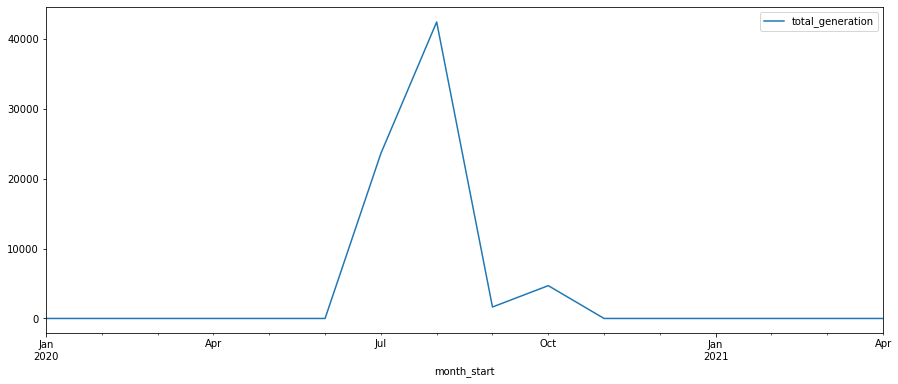

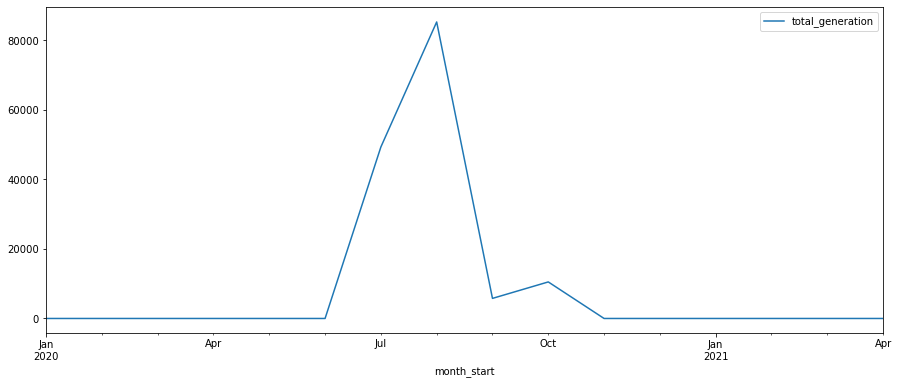

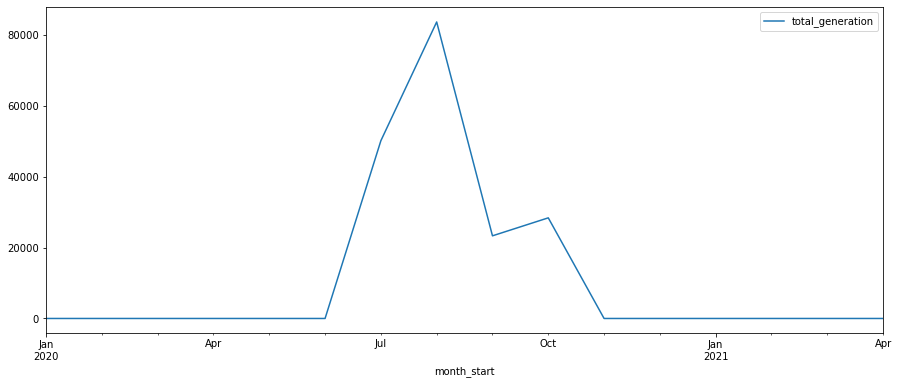

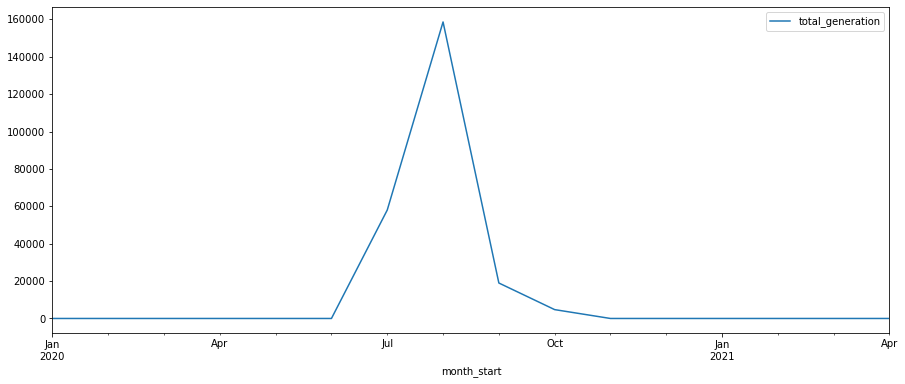

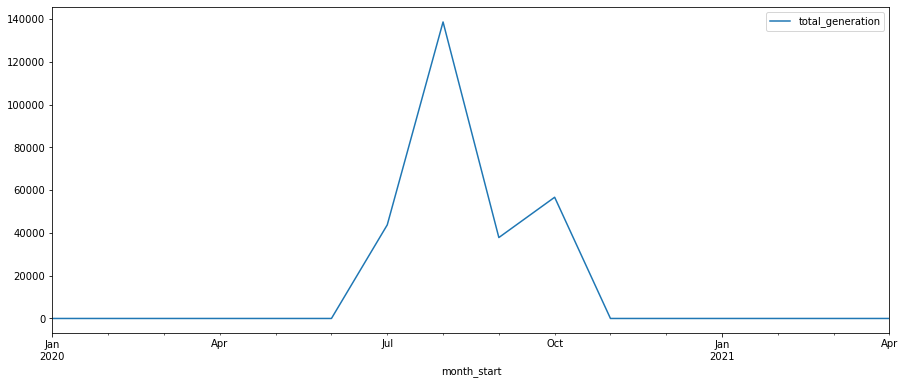

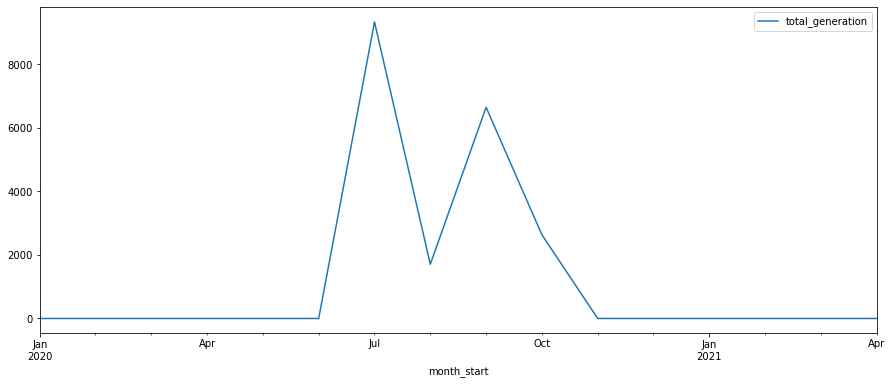

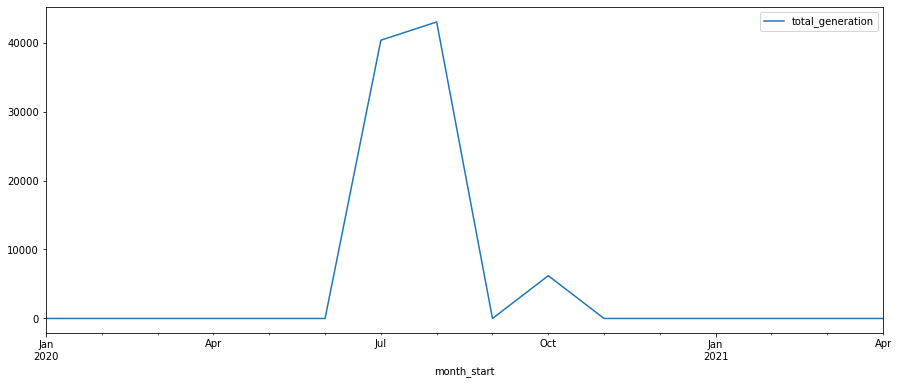

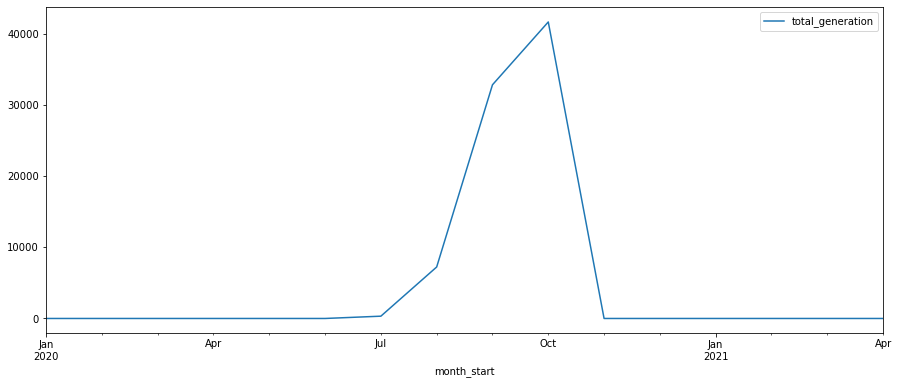

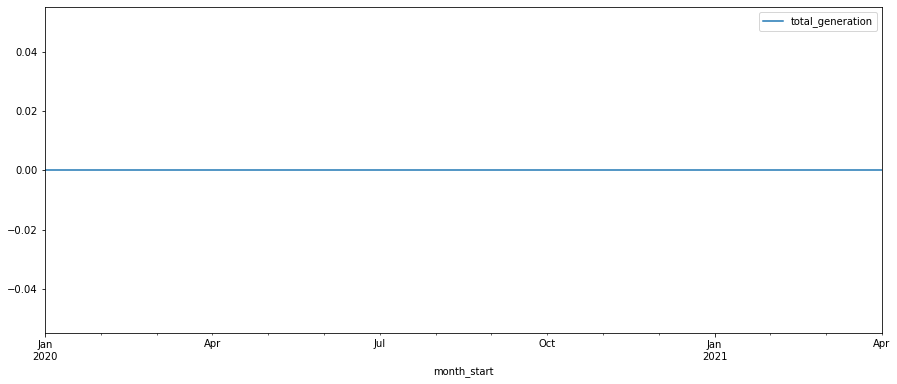

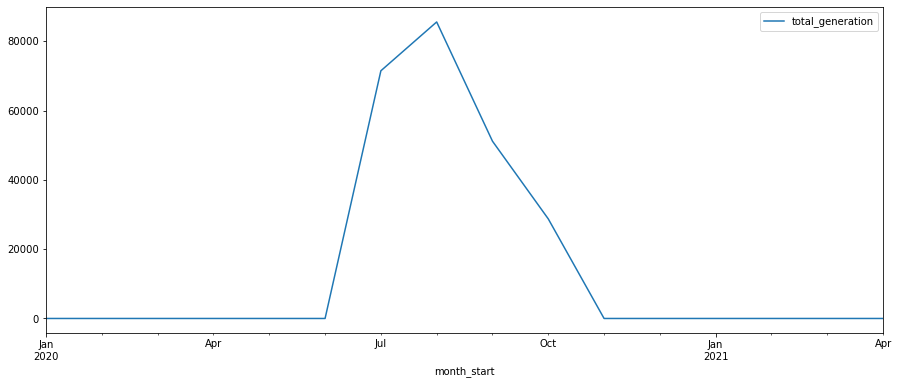

In [7]:
#quick visualisation to get a feel for the timeseries
df_visu = df_meter

df_visu['month_start'] = df_visu['local_interval_start'].to_numpy().astype('datetime64[M]')

df_visu_grouped = df_visu.groupby(
    ["meter_id", "month_start"] 
).agg(
        total_generation = ('generation_watt_hour' , 'sum')).reset_index()

df_visu_grouped =  df_visu_grouped.set_index('month_start')
df_visu_grouped.index

grouped = df_visu_grouped.groupby('meter_id')
for g in grouped.groups:
    group = grouped.get_group(g)
    group.plot(figsize=(15, 6))
    plt.show()

# Part One Answer

In [8]:
# Assumption!! that the task is to find the mean 1/4 hourly energy per month, rather than daily

df_p1_ans = df_meter.groupby(
    ["meter_id", "year" , "month"] 
).agg(
        total_energy = ('energy_watt_hour' , 'sum') ,
        mean_energy = ('energy_watt_hour' , 'mean') ,
        total_generation = ('generation_watt_hour' , 'sum')).reset_index()
 
# create local csv copy
df_p1_ans.to_csv('Part1Answer.csv')
    
print(df_p1_ans)

                                 meter_id  year  month  total_energy  \
0    0378e5be-6691-4038-910e-5f71c2c9bb24  2020      1      485631.5   
1    0378e5be-6691-4038-910e-5f71c2c9bb24  2020      2      368549.5   
2    0378e5be-6691-4038-910e-5f71c2c9bb24  2020      3      474443.5   
3    0378e5be-6691-4038-910e-5f71c2c9bb24  2020      4      414334.0   
4    0378e5be-6691-4038-910e-5f71c2c9bb24  2020      5      429654.0   
..                                    ...   ...    ...           ...   
155  c56087b0-a82c-46c4-bdf8-20ae78a186c2  2020     12      944966.0   
156  c56087b0-a82c-46c4-bdf8-20ae78a186c2  2021      1      873916.0   
157  c56087b0-a82c-46c4-bdf8-20ae78a186c2  2021      2      958324.0   
158  c56087b0-a82c-46c4-bdf8-20ae78a186c2  2021      3     1043819.0   
159  c56087b0-a82c-46c4-bdf8-20ae78a186c2  2021      4      872480.0   

     mean_energy  total_generation  
0     163.182628               0.0  
1     132.381286               0.0  
2     159.637786        

# Model creation attempts.

I have used azureml's auto ml feature to do some initial model training and testing. 

I wanted to quickly check that this problem couldn't be solved with tiem series forecasting, however through this process and a few manual model configurations I have come to the conclusion that this is a regression problem. The details of my choices are given in the part two answer section.

The below output shows the general stats for 4 run ID's.

The first was a forecasting problem based on grouped data with a month start date field and the meter_id as a sub-grouping. The final model selected was StandardScalerWrapper, XGBoostRegressor.

The second was a regression problem on ungrouped data and with the datetime decomposed into year, month , day , hour. The final model selection was MaxAbsScaler, LightGBM.

The third can be ignored

The fourth was very similar to the second but with the grouping by month and year only. the  final model selection was a voting ensemble, primarily utilising a random forest regressor.


In [9]:
# Create an Azure ML experiment 
experiment = Experiment(workspace=ws, name="leap-egeneration-forecast")

for logged_run in experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: AutoML_3bc9556f-09b4-4a8b-a375-ac597b3c28c4
- experiment_status ['DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetCrossValidationSplit', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'ModelSelection']
- experiment_status_description ['Beginning to featurize the dataset.', 'Completed featurizing the dataset.', 'Generating individually featurized CV splits.', 'Beginning to featurize the CV split.', 'Completed featurizing the CV split.', 'Beginning to featurize the CV split.', 'Completed featurizing the CV split.', 'Beginning to featurize the CV split.', 'Completed featurizing the CV split.', 'Beginning to featurize the CV split.', 'Completed featurizing the CV split.', 'Beginning to featurize the CV split.', 'Completed featurizin

Based on the above I came to the following conclusions:

1/ the seasonality of the dataset is so extreme that forecasting doesn't seem like a good idea

2/ the short timerange - grouping by month leaves us with just 15 rows per meter, with a test pot of 30% theres a good chance that we'd loose critical info.

3/ The task is to predict the monthly total, not the day, hour, minute. Additionaliy the high degree of variance in the granualar periods ( day , hour , 1/4 hour) adds noise to the model.

4/ because of the short time period we can't realy establish a trend, so a model which is based on avg's per meter while 
considering the overarching seasonaility pattern seems the best we can hope for.

5/ by useing the daily avg  i hope to smooth out the variance

6/ by keeping in the duplication caused by the day feature but removing the actual feature I hope to reduce the likelyhood that 
30% test sample will remove all of a critical piece.

7/ in order to get the end result it will be nessiary to multiply the ouput by the days of the month.

8/ I am assuming that the pattern across the majority of meters of only generating  between June and Setpember is annual and could plausably be explained by hours of sunshine and the affect that would have on solar pannels. For this reason I'll remove the data for 2021 from training.

To summarize; because of limitations in the data the best we can aim for is a model that predicts the same monthly totals for May - August 2021 as there was in 2020, per meter.


Below are the scripts for three different models used to demonstrate and select the answer to part 2.

The findings are:

1/
running with daily avg but no day feature
MSE: 1.786917888257107e-24
RMSE: 1.3367564805367906e-12
R2: 1.0

2/
re-run keeping day and targeting total - I cant see any reason why including the variation in the granular day totals would make the model any more accurate when faced with new data for May - August 2021. For all we know daily variation might even out into a consistent monthly avg.
MSE: 2501191.7505229046
RMSE: 1581.5156497875398
R2: 0.167428787995635

3/
re-run with totals at the month level
MSE: 449334005.25691366
RMSE: 21197.49997657539
R2: 0.4612282094752378


The model I have selected is model 1, with the understanding that it is severly limited and can only predict the same totals for May - August 2021 as there was in 2020.

In [10]:
df_meter = df_meter[df_meter['year'] == 2020]

In [11]:
# - Random Forest Regression  data prep 1
df_meter_grouped = df_meter.groupby(
    ["meter_id" , "month" , "day"] 
).agg(
        total_generation = ('generation_watt_hour' , 'sum')).reset_index()

df_meter_grouped = df_meter_grouped.set_index(["meter_id" , "month" ])
   

df_meter_avg = df_meter_grouped.groupby(
    ["meter_id" , "month" ] 
).agg(
        avg_generation = ('total_generation' , 'mean'))


df_meter_combo = df_meter_grouped.merge(df_meter_avg, left_on=['meter_id' , 'month'], right_on=['meter_id'  , 'month'], how='outer') 

df_meter_combo = df_meter_combo.reset_index()

df_meter_combo = df_meter_combo.drop(columns=[ 'total_generation' ,'day'])

In [12]:
# - Random Forest Regression  model training 1

# Separate features and labels
X, y = df_meter_combo[['meter_id', 'month' ]].values, df_meter_combo['avg_generation'].values

X = X.astype('str')

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


#transform the categarical columns
categorical_features = [0,1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model1 = pipeline.fit(X_train, (y_train))

MSE: 2.307403341901209e-24
RMSE: 1.519013937362396e-12
R2: 1.0


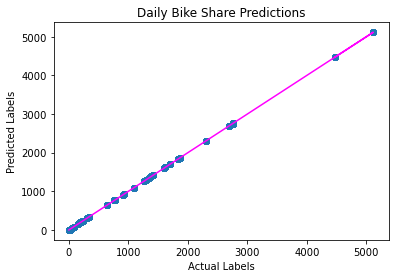

In [13]:
# Get predictions
predictions = model1.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [14]:
# - Random Forest Regression  data prep 2

df_meter_grouped2 = df_meter.groupby(
    ["meter_id" , "month" , "day"] 
).agg(
        total_generation = ('generation_watt_hour' , 'sum')).reset_index()


In [15]:
# - Random Forest Regression  model training 2

# Separate features and labels
X, y = df_meter_grouped2[['meter_id', 'month' , 'day']].values, df_meter_grouped2['total_generation'].values


# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


#transform the categarical columns
categorical_features = [0,1,2]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model2 = pipeline.fit(X_train, (y_train))

MSE: 2504505.2241623164
RMSE: 1582.5628657852162
R2: 0.16632583266910594


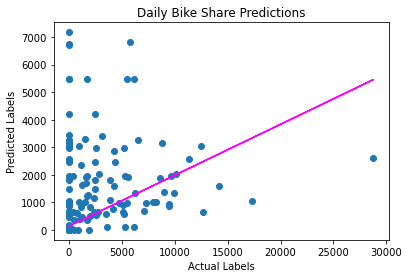

In [16]:
# Get predictions
predictions = model2.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [17]:
# - Random Forest Regression  data prep 3

df_meter_grouped3 = df_meter.groupby(
    ["meter_id", "month" ] 
).agg(
        total_generation = ('generation_watt_hour' , 'sum')).reset_index()

In [18]:
# - Random Forest Regression  model training 2

# Separate features and labels
X, y = df_meter_grouped3[['meter_id', 'month' ]].values, df_meter_grouped3['total_generation'].values


# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


#transform the categarical columns
categorical_features = [0,1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model3 = pipeline.fit(X_train, (y_train))

MSE: 485041182.6485047
RMSE: 22023.650529567178
R2: 0.41841368915676513


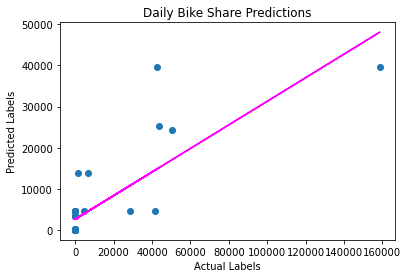

In [19]:
# Get predictions
predictions = model3.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Part 2 answer

In [20]:
# Save the model as a pickle file
filename = './emeter_generation.pkl'
joblib.dump(model1, filename)

['./emeter_generation.pkl']

In [21]:
loaded_model = joblib.load(filename)

In [22]:
# new observations
x_meters = df_meter['meter_id'].unique()
x_months = ['5','6','7','8']

X_list = list(itertools.product(x_meters, x_months ))

X_new = np.array(X_list , dtype = object)

In [23]:
results = loaded_model.predict(X_new)

for i in range(40):
    print(X_new[i] , round(results[i] * monthrange(2020, int(X_new[i , 1]))[1]))

# As outlined before, as far as I can see, due to the data limitations the best we can do is have a model that predicts 
# the average per month per meter. 


['0378e5be-6691-4038-910e-5f71c2c9bb24' '5'] 0.0
['0378e5be-6691-4038-910e-5f71c2c9bb24' '6'] 0.0
['0378e5be-6691-4038-910e-5f71c2c9bb24' '7'] 23609.0
['0378e5be-6691-4038-910e-5f71c2c9bb24' '8'] 42424.0
['060182ef-800a-4dbf-ac7d-8a75612aad7a' '5'] 0.0
['060182ef-800a-4dbf-ac7d-8a75612aad7a' '6'] 0.0
['060182ef-800a-4dbf-ac7d-8a75612aad7a' '7'] 49348.0
['060182ef-800a-4dbf-ac7d-8a75612aad7a' '8'] 85329.0
['c56087b0-a82c-46c4-bdf8-20ae78a186c2' '5'] 0.0
['c56087b0-a82c-46c4-bdf8-20ae78a186c2' '6'] 0.0
['c56087b0-a82c-46c4-bdf8-20ae78a186c2' '7'] 71471.0
['c56087b0-a82c-46c4-bdf8-20ae78a186c2' '8'] 85561.0
['c03d8e30-ce2d-4172-a6de-b589c64f458d' '5'] 0.0
['c03d8e30-ce2d-4172-a6de-b589c64f458d' '6'] 0.0
['c03d8e30-ce2d-4172-a6de-b589c64f458d' '7'] 322.0
['c03d8e30-ce2d-4172-a6de-b589c64f458d' '8'] 7227.0
['4a1c056f-204a-4cac-9d91-a4167f5416eb' '5'] 0.0
['4a1c056f-204a-4cac-9d91-a4167f5416eb' '6'] 0.0
['4a1c056f-204a-4cac-9d91-a4167f5416eb' '7'] 43773.0
['4a1c056f-204a-4cac-9d91-a4167f5416